In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time

## Prepare Data

In [2]:
df = pd.read_csv('all_english_audible6.csv')

In [3]:
# Comment this for a full run with the entire data set
# Uncomment for a quick run with a smaller data set

# df = df.sample(1000, random_state = 42)

In [4]:
df.head()

,Unnamed: 0,asin,author,category,link,narrator,price,rating,rating_count,release_date,title,Length in Minutes,Percentile Rank,Popularity,Popularity 2
0,0,0062823485,Paul Stanley,Arts & Entertainment,https://www.audible.com/pd/Backstage-Pass-Audi...,Sean Pratt,20.52,4.0,78.0,4/30/2019,Backstage Pass,278.0,0.782425,Popular,1
1,1,B0052OM9XK,Simon Pegg,Arts & Entertainment,https://www.audible.com/pd/Nerd-Do-Well-Audiob...,Simon Pegg,24.50,4.5,872.0,6/9/2011,Nerd Do Well,290.0,0.963669,Popular,1
2,2,B077XN66F8,Sidney Lumet,Arts & Entertainment,https://www.audible.com/pd/Making-Movies-Audio...,Richard M. Davidson,20.99,5.0,90.0,12/5/2017,Making Movies,443.0,0.799271,Popular,1
3,3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,https://www.audible.com/pd/Happy-Happy-Happy-A...,"Al Robertson, Phil Robertson",20.99,4.5,805.0,5/7/2013,"Happy, Happy, Happy",297.0,0.960935,Popular,1
4,4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,https://www.audible.com/pd/How-to-Listen-to-an...,Robert Greenberg,52.95,5.0,585.0,7/8/2013,How to Listen to and Understand Opera,1465.0,0.948009,Popular,1


In [5]:
df.shape

(355109, 15)

Remove unnecessary columns.

In [6]:
df.drop(['Unnamed: 0', 'link', 'Percentile Rank', 'Popularity', 'Popularity 2'], axis = 1, inplace = True)
df.head()

,asin,author,category,narrator,price,rating,rating_count,release_date,title,Length in Minutes
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78.0,4/30/2019,Backstage Pass,278.0
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872.0,6/9/2011,Nerd Do Well,290.0
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90.0,12/5/2017,Making Movies,443.0
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805.0,5/7/2013,"Happy, Happy, Happy",297.0
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585.0,7/8/2013,How to Listen to and Understand Opera,1465.0


Rename columns for easier processing.

In [7]:
df.rename(columns = {
    'asin': 'ASIN',
    'author': 'Author',
    'category': 'Category',
    'narrator': 'Narrator',
    'price': 'Price',
    'rating': 'Rating',
    'rating_count': 'RatingCount',
    'release_date': 'ReleaseDate',
    'title': 'Title',
    'Length in Minutes': 'Length'
}, inplace = True)
df.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,ReleaseDate,Title,Length
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78.0,4/30/2019,Backstage Pass,278.0
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872.0,6/9/2011,Nerd Do Well,290.0
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90.0,12/5/2017,Making Movies,443.0
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805.0,5/7/2013,"Happy, Happy, Happy",297.0
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585.0,7/8/2013,How to Listen to and Understand Opera,1465.0


Create new variable *DaysReleased* to indicate newness of items.

In [8]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])
DaysReleased = (df['ReleaseDate'] - df['ReleaseDate'].min())  / np.timedelta64(1, 'D')
df['DaysReleased'] = DaysReleased.astype('int32')

In [9]:
df.drop('ReleaseDate', axis = 1, inplace = True)
df.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,Title,Length,DaysReleased
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78.0,Backstage Pass,278.0,8521
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872.0,Nerd Do Well,290.0,5639
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90.0,Making Movies,443.0,8010
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805.0,"Happy, Happy, Happy",297.0,6337
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585.0,How to Listen to and Understand Opera,1465.0,6399


Items with Rating 5.0 is labeled as Popular for model training later.

In [10]:
# threshold = df['Rating'].quantile(0.75) # Option to use threshold at 75% percentile
df['Popular'] = np.where(df['Rating'] == 5, 1, 0)
df.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,Title,Length,DaysReleased,Popular
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78.0,Backstage Pass,278.0,8521,0
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872.0,Nerd Do Well,290.0,5639,0
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90.0,Making Movies,443.0,8010,1
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805.0,"Happy, Happy, Happy",297.0,6337,0
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585.0,How to Listen to and Understand Opera,1465.0,6399,1


In [11]:
df['Popular'].value_counts()

0    292539
1     62570
Name: Popular, dtype: int64

Check and correct the data types.

In [12]:
df.dtypes

ASIN             object
Author           object
Category         object
Narrator         object
Price           float64
Rating          float64
RatingCount     float64
Title            object
Length          float64
DaysReleased      int32
Popular           int32
dtype: object

In [13]:
df['Category'] = df['Category'].astype('category')
df['RatingCount'] = df['RatingCount'].astype('int32')
df['Length'] = df['Length'].astype('int32')

In [14]:
df.dtypes

ASIN              object
Author            object
Category        category
Narrator          object
Price            float64
Rating           float64
RatingCount        int32
Title             object
Length             int32
DaysReleased       int32
Popular            int32
dtype: object

Check for missing values.

In [15]:
df.isnull().sum()

ASIN            0
Author          0
Category        0
Narrator        0
Price           0
Rating          0
RatingCount     0
Title           0
Length          0
DaysReleased    0
Popular         0
dtype: int64

In [16]:
df.to_csv('audible_cleaned.csv', index = False)

## Explore Data

Make a copy of the dataset for exploration.

In [17]:
df_explore = df.copy()

Histograms are used to explore the spread of popular items across ranges of other variables.

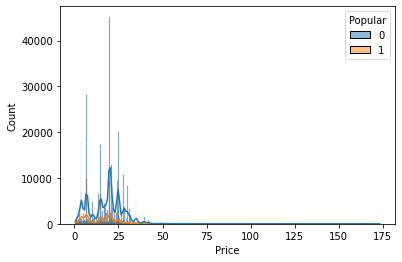

In [18]:
sns.histplot(data = df_explore, x = 'Price', hue = 'Popular', kde = True)

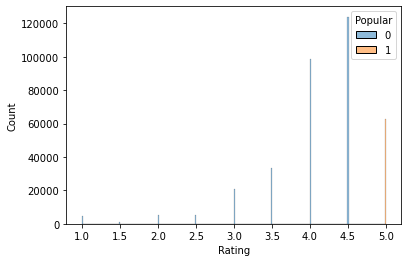

In [19]:
sns.histplot(data = df_explore, x = 'Rating', hue = 'Popular')

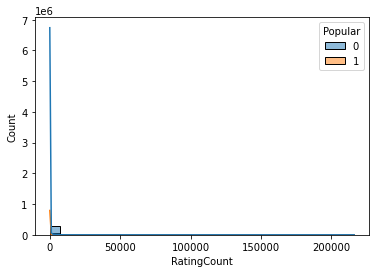

In [20]:
sns.histplot(data = df_explore, x = 'RatingCount', hue = 'Popular', kde = True, bins = 30)

RatingCount is found to be highly skewed. So it is log-transformed in a new variable RatingCountLog.

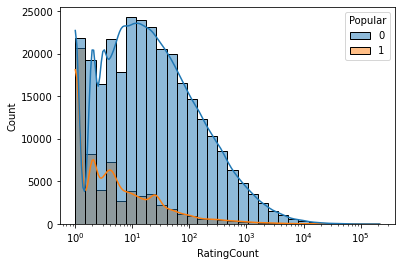

In [21]:
plt.xscale('log')
sns.histplot(data = df_explore, x = 'RatingCount', hue = 'Popular', kde = True, bins = 30)

In [22]:
df_explore['RatingCountLog'] = np.log10(df_explore['RatingCount'])
df_explore.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,Title,Length,DaysReleased,Popular,RatingCountLog
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78,Backstage Pass,278,8521,0,1.892095
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872,Nerd Do Well,290,5639,0,2.940516
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90,Making Movies,443,8010,1,1.954243
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805,"Happy, Happy, Happy",297,6337,0,2.905796
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585,How to Listen to and Understand Opera,1465,6399,1,2.767156


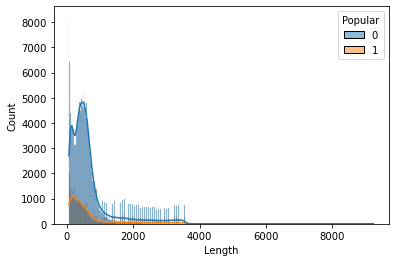

In [23]:
sns.histplot(data = df_explore, x = 'Length', hue = 'Popular', kde = True)

Length is found to be highly skewed. So it is log-transformed in a new variable LengthLog.

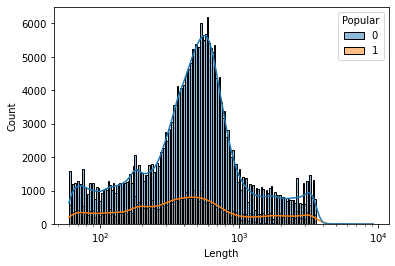

In [24]:
plt.xscale('log')
sns.histplot(data = df_explore, x = 'Length', hue = 'Popular', kde = True)

In [25]:
df_explore['LengthLog'] = np.log10(df_explore['Length'])
df_explore.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,Title,Length,DaysReleased,Popular,RatingCountLog,LengthLog
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78,Backstage Pass,278,8521,0,1.892095,2.444045
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872,Nerd Do Well,290,5639,0,2.940516,2.462398
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90,Making Movies,443,8010,1,1.954243,2.646404
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805,"Happy, Happy, Happy",297,6337,0,2.905796,2.472756
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585,How to Listen to and Understand Opera,1465,6399,1,2.767156,3.165838


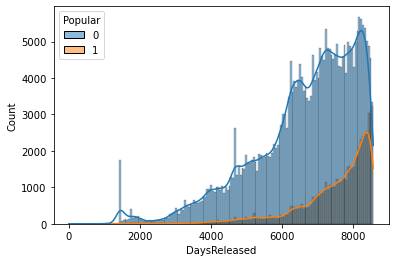

In [26]:
sns.histplot(data = df_explore, x = 'DaysReleased', hue = 'Popular', kde = True)

DaysReleased is found to be highly skewed. So it is log-transformed in a new variable DaysReleasedLog.

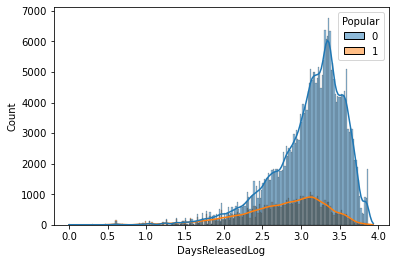

In [27]:
df_explore['DaysReleasedLog'] = np.log10(df['DaysReleased'].max() + 1 - df['DaysReleased'])
sns.histplot(data = df_explore, x = 'DaysReleasedLog', hue = 'Popular', kde = True)

Scatter plots are used to discover relationship between the Popular variable and other variables.

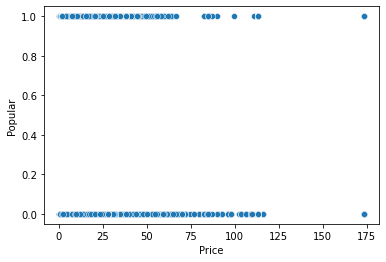

In [28]:
sns.scatterplot(data = df_explore, x = 'Price', y = 'Popular')

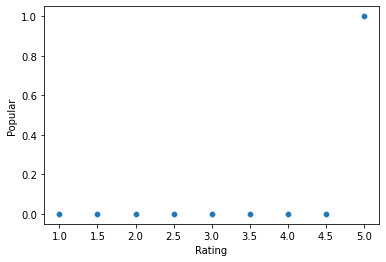

In [29]:
sns.scatterplot(data = df_explore, x = 'Rating', y = 'Popular')

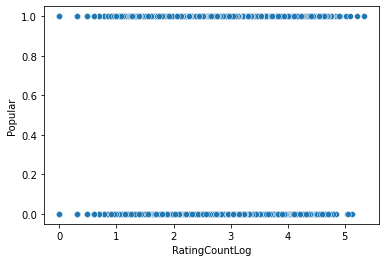

In [30]:
sns.scatterplot(data = df_explore, x = 'RatingCountLog', y = 'Popular')

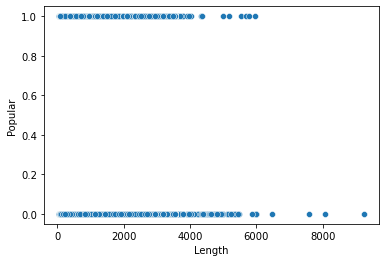

In [31]:
sns.scatterplot(data = df_explore, x = 'Length', y = 'Popular')

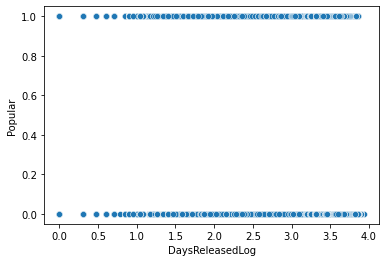

In [32]:
sns.scatterplot(data = df_explore, x = 'DaysReleasedLog', y = 'Popular')

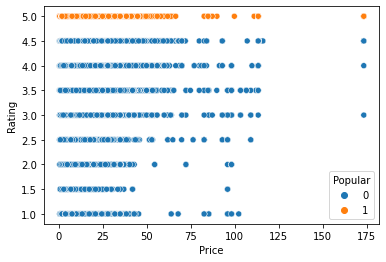

In [33]:
sns.scatterplot(data = df_explore, x = 'Price', y = 'Rating', hue = 'Popular')

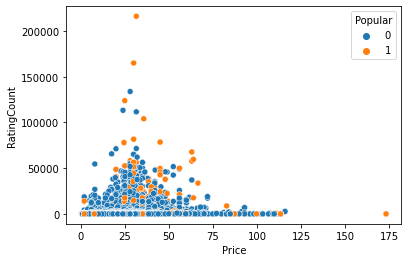

In [34]:
sns.scatterplot(data = df_explore, x = 'Price', y = 'RatingCount', hue = 'Popular')

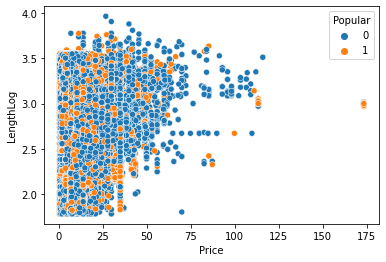

In [35]:
sns.scatterplot(data = df_explore, x = 'Price', y = 'LengthLog', hue = 'Popular')

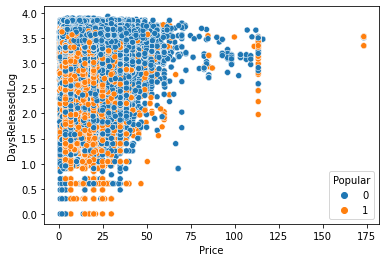

In [36]:
sns.scatterplot(data = df_explore, x = 'Price', y = 'DaysReleasedLog', hue = 'Popular')

Bar plot is used to explore the relationship of various categories to the Popular variable.

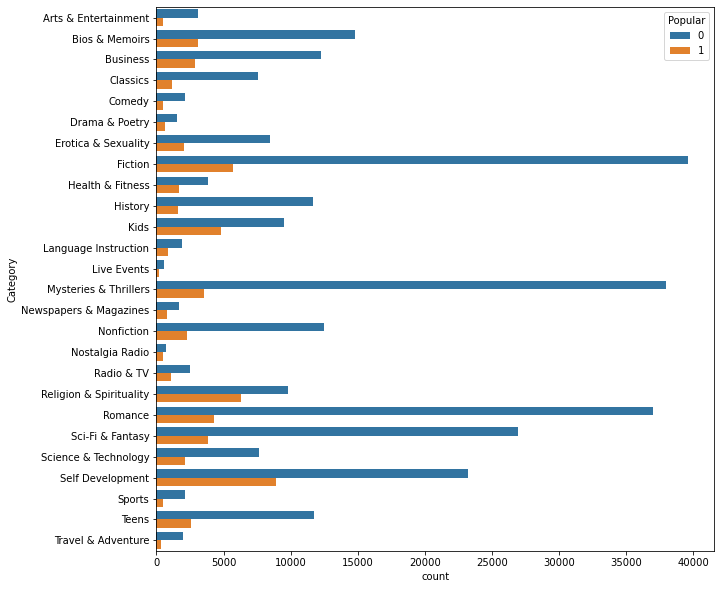

In [37]:
plt.figure(figsize = (10, 10))
sns.countplot(data = df_explore, y = 'Category', hue = 'Popular')

The 'Self Development' category seems to have a high proportion of popular items. So a new variable is created to indicate whether an item belong to this category or not.

In [38]:
SelfDevelopment = np.where(df_explore['Category'] == 'Self Development', 1, 0)
df_explore.insert(10, 'SelfDevelopment', SelfDevelopment)
df_explore.head()

,ASIN,Author,Category,Narrator,Price,Rating,RatingCount,Title,Length,DaysReleased,SelfDevelopment,Popular,RatingCountLog,LengthLog,DaysReleasedLog
0,0062823485,Paul Stanley,Arts & Entertainment,Sean Pratt,20.52,4.0,78,Backstage Pass,278,8521,0,0,1.892095,2.444045,1.778151
1,B0052OM9XK,Simon Pegg,Arts & Entertainment,Simon Pegg,24.50,4.5,872,Nerd Do Well,290,5639,0,0,2.940516,2.462398,3.468643
2,B077XN66F8,Sidney Lumet,Arts & Entertainment,Richard M. Davidson,20.99,5.0,90,Making Movies,443,8010,0,1,1.954243,2.646404,2.756636
3,B00C75YMJ6,Phil Robertson,Arts & Entertainment,"Al Robertson, Phil Robertson",20.99,4.5,805,"Happy, Happy, Happy",297,6337,0,0,2.905796,2.472756,3.351023
4,B00DCD16GE,"Robert Greenberg, The Great Courses",Arts & Entertainment,Robert Greenberg,52.95,5.0,585,How to Listen to and Understand Opera,1465,6399,0,1,2.767156,3.165838,3.338855


## Feature Engineering

In this part, the set of features used for model training is selected using logistic regression as a baseline model.

Extract the Popular variable as the label for model training.

In [39]:
labels = df_explore['Popular']
labels

0         0
1         0
2         1
3         0
4         1
         ..
355104    0
355105    1
355106    1
355107    0
355108    0
Name: Popular, Length: 355109, dtype: int32

In [40]:
labels.value_counts()

0    292539
1     62570
Name: Popular, dtype: int64

5 feature sets are candidates for the final choices. Each set is fed into the baseline model to find out the best feature set with the highest accuracy score.

In [41]:
FeatureSets = [
    ['Price', 'RatingCountLog', 'LengthLog', 'DaysReleasedLog', 'SelfDevelopment'],
    ['Price', 'LengthLog', 'DaysReleasedLog', 'SelfDevelopment'],
    ['Price', 'LengthLog', 'DaysReleasedLog'],
    ['Price', 'LengthLog'],
    ['Price']
]

In [42]:
scaler = StandardScaler()
LR = LogisticRegression()

In [43]:
highest = 0

for FeatureSet in FeatureSets:
    print('Exploring ' + str(FeatureSet))
    
    features = scaler.fit_transform(df_explore[FeatureSet])
    features = pd.DataFrame(features, columns = FeatureSet)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)
    
    LR.fit(X_train, y_train)
    predictions = LR.predict(X_test)
    score = LR.score(X_test, y_test)
    
    if score >= highest:
        highest = score
        SelectedFeatureSet = FeatureSet.copy()
    
    print('Accuracy score: ' + str(score))
    print()
    
print('Selected feature set: ' + str(SelectedFeatureSet))
print('Accuracy score: ' + str(highest))

Exploring ['Price', 'RatingCountLog', 'LengthLog', 'DaysReleasedLog', 'SelfDevelopment']
Accuracy score: 0.8242446002647067

Exploring ['Price', 'LengthLog', 'DaysReleasedLog', 'SelfDevelopment']
Accuracy score: 0.8238433161555574

Exploring ['Price', 'LengthLog', 'DaysReleasedLog']
Accuracy score: 0.823209709667427

Exploring ['Price', 'LengthLog']
Accuracy score: 0.8224493818816705

Exploring ['Price']
Accuracy score: 0.8224493818816705

Selected feature set: ['Price', 'RatingCountLog', 'LengthLog', 'DaysReleasedLog', 'SelfDevelopment']
Accuracy score: 0.8242446002647067


The selected feature set is scaled to avoid bias in model training.

In [44]:
features = scaler.fit_transform(df_explore[SelectedFeatureSet])
features = pd.DataFrame(features, columns = SelectedFeatureSet)
features

,Price,RatingCountLog,LengthLog,DaysReleasedLog,SelfDevelopment
0,0.329443,0.782743,-0.512537,-2.612469,-0.315248
1,0.753424,1.994469,-0.465666,0.842844,-0.315248
2,0.379511,0.854571,0.004255,-0.612476,-0.315248
3,0.379511,1.954341,-0.439212,0.602433,-0.315248
4,3.784146,1.794106,1.330808,0.577561,-0.315248
...,...,...,...,...,...
355104,-0.788036,-0.708231,-1.160480,1.148652,-0.315248
355105,-1.040508,-1.404069,-2.107414,1.037903,-0.315248
355106,0.377380,-1.404069,-0.137072,1.126572,-0.315248
355107,0.377380,-1.404069,-0.477199,1.062270,-0.315248


The dataset is split into training set (60%) and test set (40%).

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)

In [46]:
X_train.to_csv('train_features.csv', index = False)
X_test.to_csv('test_features.csv', index = False)

y_train.to_csv('train_labels.csv', index = False)
y_test.to_csv('test_labels.csv', index = False)

In [47]:
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

## Machine Learning

3 algorithm are used for training model - Logistic Regression, Random Forest, Gradient Boosting. 

For each algorithm, 5-fold cross validation is used to reduce bias during training. A set of hyperparameters in each algorith are used to tune the model for the best results. The best model for each algorithm is then stored for comparison later.

A function to print model training result for each algorithm later.

In [48]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

### Model 1 - Logistic Regression

In [49]:
model = LogisticRegression(max_iter = 1000)

# Use this for quick test
# parameters = {'C': [1], 'max_iter': [1000]}

# Use this for normal run
parameters = {'C': [0.1, 1], 'max_iter': [500, 1000]}

# Use this if there is extensive computing power
# parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [100, 500, 1000]}

In [50]:
cv = GridSearchCV(model, parameters, cv = 5)
cv.fit(train_features, train_labels.values.ravel())
print_results(cv)

BEST PARAMS: {'C': 1, 'max_iter': 500}

0.826 (+/-0.002) for {'C': 0.1, 'max_iter': 500}
0.826 (+/-0.002) for {'C': 0.1, 'max_iter': 1000}
0.826 (+/-0.002) for {'C': 1, 'max_iter': 500}
0.826 (+/-0.002) for {'C': 1, 'max_iter': 1000}


In [51]:
cv.best_estimator_

LogisticRegression(C=1, max_iter=500)

In [52]:
joblib.dump(cv.best_estimator_, 'LR_model.pkl')

['LR_model.pkl']

### Model 2 - Random Forest

In [53]:
model = RandomForestClassifier()

# Use this for quick test
# parameters = {'n_estimators': [50], 'max_depth': [32]}

# Use this for normal run
parameters = {'n_estimators': [5, 50], 'max_depth': [16, 32]}

# Use this if there is extensive computing power
# parameters = {'n_estimators': [5, 50, 250], 'max_depth': [2, 4, 8, 16, 32, None]}

In [54]:
cv = GridSearchCV(model, parameters, cv = 5)
cv.fit(train_features, train_labels.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 32, 'n_estimators': 50}

0.839 (+/-0.003) for {'max_depth': 16, 'n_estimators': 5}
0.846 (+/-0.002) for {'max_depth': 16, 'n_estimators': 50}
0.837 (+/-0.002) for {'max_depth': 32, 'n_estimators': 5}
0.853 (+/-0.002) for {'max_depth': 32, 'n_estimators': 50}


In [55]:
joblib.dump(cv.best_estimator_, 'RF_model.pkl')

['RF_model.pkl']

### Model 3 - Gradient Boosting

In [56]:
model = GradientBoostingClassifier()

# Use this for quick test
# parameters = {'n_estimators': [50], 'max_depth': [3], 'learning_rate': [0.1]}

# Use this for normal run
parameters = {'n_estimators': [5, 50], 'max_depth': [3, 5], 'learning_rate': [0.1, 1]}

# Use this if there is extensive computing power
# parameters = {'n_estimators': [5, 50, 250, 500], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [0.01, 0.1, 1, 10, 100]}

In [57]:
cv = GridSearchCV(model, parameters, cv = 5)
cv.fit(train_features, train_labels.values.ravel())
print_results(cv)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

0.825 (+/-0.0) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}
0.834 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.825 (+/-0.0) for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 5}
0.837 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
0.83 (+/-0.002) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 5}
0.836 (+/-0.003) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}
0.835 (+/-0.003) for {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 5}
0.836 (+/-0.002) for {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 50}


In [58]:
joblib.dump(cv.best_estimator_, 'GB_model.pkl')

['GB_model.pkl']

## Evaluating Models

The 3 models are now tested using the test set to decide the best model to use. The metrics used for evaluation is accuracy score (Jaccard similarity coefficient), precision, recall, F1 score.

In [59]:
test_features = pd.read_csv('test_features.csv')
test_labels = pd.read_csv('test_labels.csv')

In [60]:
models = {}

for mdl in ['LR', 'RF', 'GB']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))
    
models

{'LR': LogisticRegression(C=1, max_iter=500),
 'RF': RandomForestClassifier(max_depth=32, n_estimators=50),
 'GB': GradientBoostingClassifier(max_depth=5, n_estimators=50)}

In [61]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    f1 = round(f1_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / F1: {} / Latency: {}ms'.
          format(name, accuracy, precision, recall, f1, round((end - start)*1000, 1)))

In [62]:
# Test with test set
for name, mdl in models.items():
    evaluate_model(name, mdl, test_features, test_labels)

LR -- Accuracy: 0.824 / Precision: 0.522 / Recall: 0.121 / F1: 0.196 / Latency: 71.8ms
RF -- Accuracy: 0.859 / Precision: 0.654 / Recall: 0.433 / F1: 0.521 / Latency: 6974.1ms
GB -- Accuracy: 0.835 / Precision: 0.602 / Recall: 0.216 / F1: 0.318 / Latency: 492.7ms


While the accuracy score is good for all three models, the other metrics do not fare so well. Let's cross check by testing the models on training set and the entire data set.

In [63]:
# Test with training set
for name, mdl in models.items():
    evaluate_model(name, mdl, train_features, train_labels)

LR -- Accuracy: 0.826 / Precision: 0.517 / Recall: 0.119 / F1: 0.193 / Latency: 22.5ms
RF -- Accuracy: 0.997 / Precision: 0.996 / Recall: 0.987 / F1: 0.991 / Latency: 8584.3ms
GB -- Accuracy: 0.84 / Precision: 0.618 / Recall: 0.223 / F1: 0.328 / Latency: 748.5ms


In [64]:
# Test with entire data set
for name, mdl in models.items():
    evaluate_model(name, mdl, features, labels)

LR -- Accuracy: 0.825 / Precision: 0.519 / Recall: 0.12 / F1: 0.194 / Latency: 148.4ms
RF -- Accuracy: 0.942 / Precision: 0.89 / Recall: 0.763 / F1: 0.822 / Latency: 11931.0ms
GB -- Accuracy: 0.838 / Precision: 0.612 / Recall: 0.22 / F1: 0.324 / Latency: 1042.0ms


Random Forest might have been overfitting for the training set, resulting in an especially high score for all metrics. 

However, Random Forest is still the best among all 3 models given the entire data set. Therefore, it is the model of choice for this project.

## Final Model - Random Forest

This is the final model with parameters below.

In [65]:
models['RF']

RandomForestClassifier(max_depth=32, n_estimators=50)